##   Pytorch  GAN 을 통해서 그림 생성하기

실습모드로 돌려보기  by colaboratory :
https://colab.research.google.com/drive/1Do_qSoUUC1cP0k7tmYfPzndlumqUm3z_

코드 https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/406_GAN.ipynb

In [0]:
#  pytorch 설치
!pip3 install torch torchvision

간단 요약 : GAN  은 데이터를 학습해서 그 데이터와 비슷한  output 을 출력해주는 모델로  Generator  와  Criminator 두 네트워크가 있다.  Generator 는  output 을 잘 만들고자 하는 목표를 가지고 학습을 하고  Ciminator 는 가짜  output 과   진짜  output 을 잘 구분하고자 하는 목표를 가지고 학습을 한다. 두 모델의  loss 가 최소화되는 지점으로 학습을 하게 된다.

In [0]:
import  torch
import  torch.nn  as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)    # reproducible
np.random.seed(1)

In [0]:
# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)]) 


 np.linspace 를 통해 -1부터 1까지 15개의 일정한 간격의 수를  batch_size 만큼 반복해서 생성 후 ,  np.vstack 을 통해서  각각의  array 를  vertically stacked 된 한개의  array 로 만들어준다.

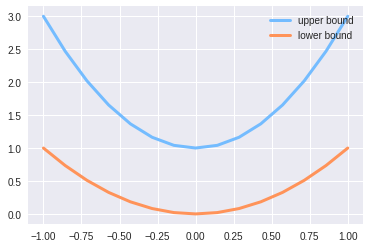

In [8]:
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()
# 우리가 만들고자 하는 함수의  min, max boundary이다.

아래의 함수를 통해 우리는 진짜  artist_works 를 무한히 생성한다고 가정한다.

In [0]:
def artist_works():     # painting from the famous artist (real target)
    # GAN  모델이 그리고자 하는 타겟은  PAINT_POINTS 에다가 1,2 사이에서 랜덤하게 뽑은 수를 곱하고 더한값
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    paintings = torch.from_numpy(paintings).float()
    return Variable(paintings)  

다음은  generator 와 criminator를 만드는 함수이다.

In [0]:
 G = nn.Sequential( # layer 를 순차적으로 쌓음 #  Generator
  nn.Linear(N_IDEAS,128),
  nn.ReLU(),
  nn.Linear(128, ART_COMPONENTS),
 )  
 # 간단하게  linear 로 5개의 랜덤 인풋을 통해 128개의 hidden layer 통과시키고,  
 #nonlinear  함수인 Relu 를 통과한  output 을 다시 15개의  output 으로 내보내는 Generator 이다.
  
D = nn.Sequential(
nn.Linear(ART_COMPONENTS,128),
nn.ReLU(),
nn.Linear(128,1),
nn.Sigmoid(),
)
#   ART_COMPONENTS 를 받아서 이 그림이 진짜인지 가짜인지를 판단.

In [0]:
# 아래는 D 와  G 를 학습시키기 위한   optimizer 이다
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

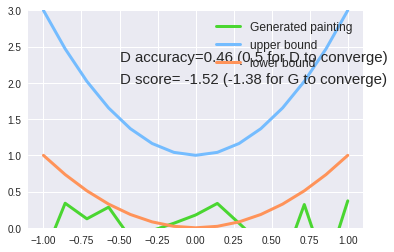

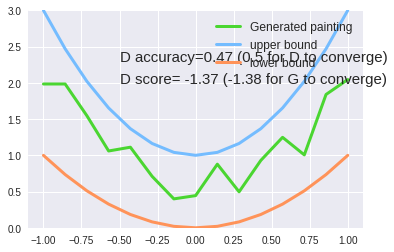

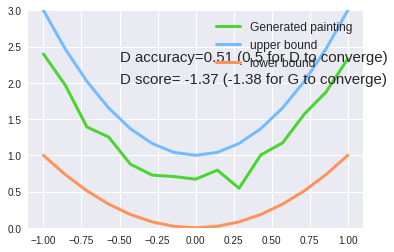

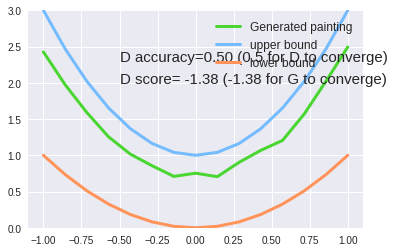

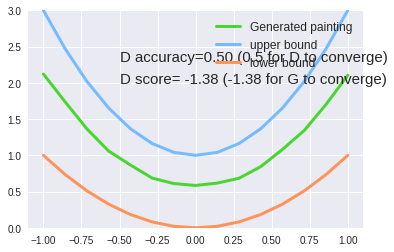

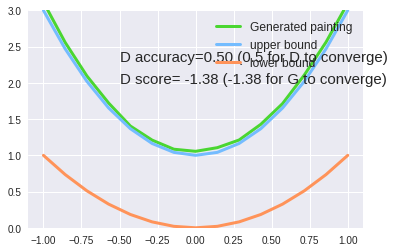

KeyboardInterrupt: ignored

In [14]:
for step in range(10000):
    artist_paintings = artist_works()           # real painting 생성
    G_ideas = Variable(torch.randn(BATCH_SIZE, N_IDEAS))    # random ideas 를 128, 5차원으로 생성
    G_paintings = G(G_ideas)                    #  generator 를 통해서 가짜 그림 생성

    prob_artist0 = D(artist_paintings)          # D try to increase this prob #  artist_painting  이 진짜 그림이니까 진짜라고 맞추어야 함
    prob_artist1 = D(G_paintings)               # D try to reduce this prob # 이건 가짜 그림이니까 가짜라고 맞추어야 함
    # 그래서 아래와 같은 로스 함수 사용
    #   가짜 그림 Generator는  Discriminator 가 잘 속는 그림을 만드는 것이 목표
    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    G_loss = torch.mean(torch.log(1. - prob_artist1))

    ## 두 모델을 다음과 같이 학습시킴
    opt_D.zero_grad()
    D_loss.backward( retain_graph=True)      
    # retain_variables for reusing computational graph
    # retain_variables=True  가 0.4 버전에서는  retain_graph=True 로
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if step % 1000 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 15})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=12);plt.draw();plt.pause(0.01)
        plt.show()